I’ve been recently refreshing my finite element skills and found a fun problem that appears when working with 2D meshes made of triangles.

The problem is as follows: "Given any 2D triangle T defined by its vertices, can I map it to a reference triangle with vertices (0, 0), (1, 0) and (0, 1)?".

It turns out that this is true, and an analytical expression for this exists. Let’s do some plots and find out.

We will use complex numbers to instantiate points in the plane. Let’s start by defining the reference triangle and a plotting function for triangles.

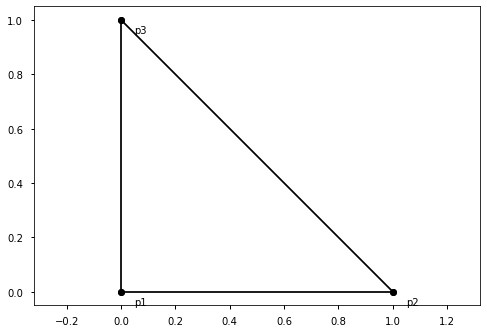

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")

ref_triangle = [0 + 0j, 1 + 0j, 0 + 1j]

def plot_tri(tri, ax, label=True, style="-ok"):
    for i in range(3):
        p1 = tri[i]
        p2 = tri[(i + 1) % 3]
        ax.plot([p1.real, p2.real], 
                [p1.imag, p2.imag], style)
        if label: 
            ax.text(p1.real + 0.05, p1.imag - 0.05, f"p{i+1}")

fig, ax = plt.subplots()
ax.axis("equal")
plot_tri(ref_triangle, ax)

The math part: if we search for a transformation defined by a matrix product and a translation that transforms reference point $\hat{M}_i$ into the triangle point $M_i$, it turns out that we are searching for six unknowns based on six equations

$$
\forall i \in [1, 3] \, 
\left [ 
\begin{array}[] 
aa & b \\
c & d
\end{array}
\right ]
\left [ 
\begin{array}[] 
\\\hat{M}_{ix} \\
\hat{M}_{iy} 
\end{array}
\right ] +
\left [ 
\begin{array}[] 
\\e \\
f
\end{array}
\right ] = 
\left [ 
\begin{array}[] 
\\M_{ix} \\
M_{iy} 
\end{array}
\right ]
$$

This can be solved by substituting the successive results of the three equations and can be implemented as follows:

In [2]:
import numpy as np

def make_transformation(tri):
    p1, p2, p3 = tri
    e, f = p1.real, p1.imag
    a, c = p2.real - e, p2.imag - f
    b, d = p3.real - e, p3.imag - f
    
    return np.array([[a, b], 
                     [c, d]]), np.array([[e],
                                         [f]])

Let’s define our test triangle and compute the transformation.

In [3]:
test_tri = [1 + 1j, 2 + 2j, 4j]

transform = make_transformation(test_tri)

transform

(array([[ 1., -1.],
        [ 1.,  3.]]),
 array([[1.],
        [1.]]))

Let’s see if the transformation is correct on our reference points. We start with the first point.

In [4]:
def apply_transformation(transform, p):
    p_vec = np.array([[p.real], [p.imag]])
    b, m = transform
    new_p = np.dot(b, p_vec) + m
    return complex(new_p[0] + 1j * new_p[1])

apply_transformation(transform, ref_triangle[0])

(1+1j)

This seems correct. We can loop over all the points to check this works as expected.

In [5]:
for i in range(3):
    print(apply_transformation(transform, ref_triangle[i]), "->", test_tri[i])

(1+1j) -> (1+1j)
(2+2j) -> (2+2j)
4j -> 4j


Let’s now make a plot showing how one triangle transforms into the other.

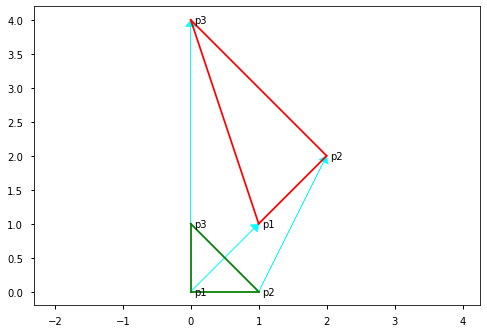

In [6]:
fig, ax = plt.subplots()
ax.axis("equal")
plot_tri(ref_triangle, ax, style="-g")

for i in range(3):
    p1 = ref_triangle[i]
    p2 = apply_transformation(transform, p1)
    ax.arrow(p1.real, p1.imag, p2.real - p1.real, p2.imag - p1.imag, head_width=0.15, head_length=0.1, fc='cyan', ec='cyan', lw=0.5, length_includes_head=True)
    
plot_tri(test_tri, ax, style="-r")


We can go further and mesh a little region around our triangle and see how it transforms.

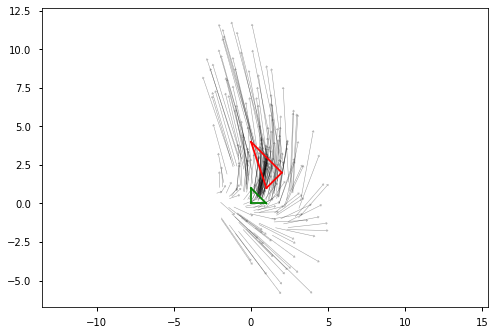

In [7]:
def plot_arrows(center=(0.5, 0.5), n_points=200):
    points = []
    for i in range(n_points):
        r, theta = np.random.uniform(low=0, high=3, size=1), np.random.uniform(low=-np.pi, high=np.pi, size=1)
        x, y = r * np.cos(theta), r * np.sin(theta)
        x += center[0]
        y += center[1]
        points.append(complex(x + 1j * y))

    fig, ax = plt.subplots()
    ax.axis("equal")

    plot_tri(ref_triangle, ax, label=False, style="-g")
    plot_tri(test_tri, ax, label=False, style="-r")

    for p1 in points:
        p2 = apply_transformation(transform, p1)
        ax.arrow(p1.real, p1.imag, p2.real - p1.real, p2.imag - p1.imag, head_width=0.15, head_length=0.1, fc='k', ec='k', lw=0.5, alpha=0.2, length_includes_head=True)


plot_arrows()

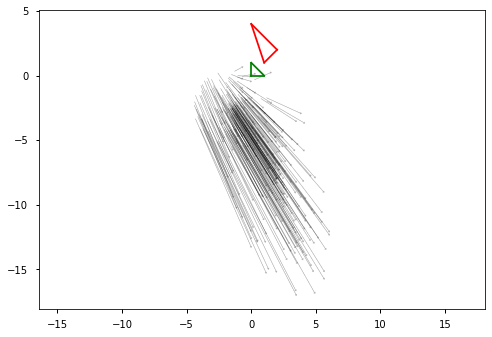

In [8]:
plot_arrows(center=(-1.5, -2.5))

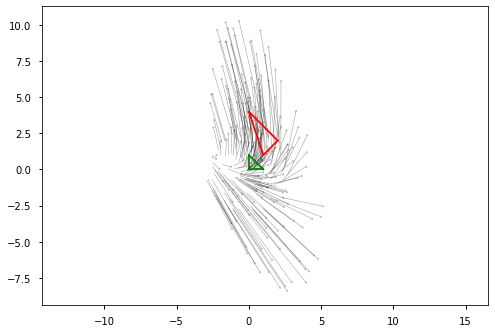

In [9]:
plot_arrows(center=(0, 0))

To finish this off, let’s try a little animation:

In [10]:
import matplotlib.animation as manim
from IPython.display import HTML

points = []
for i in range(200):
    r, theta = np.random.uniform(low=0, high=3, size=1), np.random.uniform(low=-np.pi, high=np.pi, size=1)
    points.append(complex(r + 1j * theta))

fig, ax = plt.subplots()
ax.axis("equal")

lims = (-14.034433006601324,
 15.988924988701493,
 -8.839829831047396,
 11.268556310161467)

def plot_anim(t):
    ax.clear()
    plot_tri(ref_triangle, ax, label=False, style="-g")
    plot_tri(test_tri, ax, label=False, style="-r")

    theta_offset = 2 * np.pi * t
    artists = []
    for r_theta in points:
        r, theta = r_theta.real, r_theta.imag + theta_offset
        p1 = complex( r * np.cos(theta) + 1j * r * np.sin(theta))
        p2 = apply_transformation(transform, p1)
        artist = ax.arrow(p1.real, p1.imag, p2.real - p1.real, p2.imag - p1.imag, head_width=0.15, head_length=0.1, fc='k', ec='k', lw=0.5, alpha=0.2, length_includes_head=True)
        artists.append(artist)
    ax.axis(lims)
    return artists

anim = manim.FuncAnimation(fig, plot_anim, frames=np.linspace(0, 1, num=50, endpoint=False), blit=False)

plt.close(fig)
HTML(anim.to_jshtml())

It’s interesting to look at these vector fields. 

Of course the interesting part about all of this is: why would you want to perform this mapping to a reference triangle. For finite elements, the reason is that this makes it much easier to apply quadrature formulas, which allow for a very high accuracy in the computation of the integrals that make up the linear system derived by using the finite element method.

As a side note, there exists a similar problem mapping squares to squares (see [here](https://math.stackexchange.com/questions/13404/mapping-irregular-quadrilateral-to-a-rectangle)).


*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20211103_finite_elements_triangle_mapping.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20211103_finite_elements_triangle_mapping.ipynb).*